In [1]:
cd ..

/home/thejevans/git/umd_icecube_analysis_tutorial


In [2]:
import numpy as np
from analysis import tools
from analysis.time_profiles import gauss_profile
from analysis.time_profiles import uniform_profile
from analysis.llhs import ps_flare_llh
import test.test_data as test_data
import glob
from scipy import stats
from matplotlib import pyplot as plt

np.random.seed(0)

In [3]:
# Load in both the simulation and the data

# # Where is the dataset stored?
# dataset = "/data/mjlarson/data/"

# # Read in all of the data files
# data_files = dataset + "/IC86_*exp.npy"
# data = tools.read(glob.glob(data_files))

# # Read in all of the MC files 
# sim_files = dataset + "/IC86*MC*npy"
# sim = tools.read(glob.glob(sim_files))

data_size = 1000
sim_size = 10000

data = test_data.get_random_data(data_size)
sim = test_data.get_random_sim(sim_size)

# Set the angular error floor to 0.2 degrees
data['angErr'][data['angErr']<np.deg2rad(0.2)] = np.deg2rad(0.2)
sim['angErr'][sim['angErr']<np.deg2rad(0.2)] = np.deg2rad(0.2)


# Show the possible keys available here:
print("Events available in simulation: {}".format(len(sim)))
print("Keys available in simulation:")
print(sorted(sim.dtype.names))
print()

print("Events available in data: {}".format(len(data)))
print("Keys available in data:")
print(sorted(data.dtype.names))

Events available in simulation: 10000
Keys available in simulation:
['angErr', 'azi', 'dec', 'event', 'logE', 'ow', 'ra', 'run', 'subevent', 'time', 'trueDec', 'trueE', 'trueRa', 'zen']

Events available in data: 1000
Keys available in data:
['angErr', 'azi', 'dec', 'event', 'logE', 'ra', 'run', 'subevent', 'time', 'zen']


In [4]:
# # Also load in the "GoodRunList" (GRL), a file that tells
# # us when the detector was taking good data. 
# grl_files = dataset + "/GRL/IC86_*exp.npy"
# grl = tools.read(glob.glob(grl_files))
grl = test_data.get_random_grl(data)


# Show the keys available in the GRL
print("Keys available in the GoodRunList:")
print(sorted(grl.dtype.names))

gammas = np.arange(-4.25, -0.5, 0.25)
bins   = np.array([np.linspace(-1, 1, 51), # sin(dec)
                   np.linspace(1, 8, 51)]) # logE

Keys available in the GoodRunList:
['events', 'livetime', 'run', 'start', 'stop']


In [5]:
# Try this with a gaussian signal + uniform background.
signal_time_profile = gauss_profile.GaussProfile(56102.5, 0.01)
background_time_profile = uniform_profile.UniformProfile(56102.48, 56102.52)
source = {'ra':np.pi/2, 'dec':np.pi/6}

In [6]:
# Run this block once
llh_object = ps_flare_llh.PsFlareLLH(data, sim, grl, gammas, bins, outfile = './test/test_outputs/ps_flare_llh-test.npy', source = source,
                                     signal_time_profile = signal_time_profile, background_time_profile = background_time_profile)

  0%|          | 0/15 [00:00<?, ?it/s]/home/thejevans/git/umd_icecube_analysis_tutorial/analysis/llhs/ps_flare_llh.py:93: RuntimeWarning: divide by zero encountered in true_divide
  ratio = sig_h / bg_h
/home/thejevans/git/umd_icecube_analysis_tutorial/analysis/llhs/ps_flare_llh.py:93: RuntimeWarning: invalid value encountered in true_divide
  ratio = sig_h / bg_h
100%|██████████| 15/15 [00:00<00:00, 181.61it/s]
/home/thejevans/git/umd_icecube_analysis_tutorial/analysis/llhs/ps_flare_llh.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.save(outfile, np.array([self.sob_maps, self.bg_p_dec]))


In [7]:
# Afterwards, run this one to save time
llh_object = ps_flare_llh.PsFlareLLH(data, sim, grl, gammas, bins, infile = './test/test_outputs/ps_flare_llh-test.npy', source = source,
                                     signal_time_profile = signal_time_profile, background_time_profile = background_time_profile)

In [8]:
# Produce a single trial. Here, we pass a "seed"
# value to the function so that we can reproduce
# the trial later if we want to. If you want it to
# be random, set seed=None.
seed = 0

trial = llh_object.produce_trial(N=1e-15, random_seed=seed)
print("Got {} events for this trial".format(len(trial)))

print("Times:")
print(trial)

Got 0 events for this trial
Times:
[]


In [9]:
# Run the function with our test trial. Make sure
# you understand what's getting returned!
bestfit = llh_object.evaluate_ts(trial, ns=4, gamma=-2)
print(bestfit)

{'ts': nan, 'ns': 4, 'gamma': -2, 'gauss_tp_mean': 56102.5, 'gauss_tp_sigma': 0.01}


In [10]:
# Run trials for a few different values of N. These settings should
# exactly mimic your previous script
thousand_seconds = (1000.0)/(24*3600.)
llh_object.background_time_profile = uniform_profile.UniformProfile(56044.0912963, 56044.0912963+thousand_seconds)
llh_object.signal_time_profile = llh_object.background_time_profile

background_fits = llh_object.produce_n_trials(1000, test_ns = 0.1)
signal_16_fits = llh_object.produce_n_trials(1000, N=1e-16, test_ns = 0.1)
signal_15_fits = llh_object.produce_n_trials(1000, N=1e-15, test_ns = 0.1)
signal_14_fits = llh_object.produce_n_trials(1000, N=1e-14, test_ns = 0.1)

Running Trials (N=0.00e+00, gamma=-2.0):   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 0/1000 [00:00<?, ? trials/s]

ERROR: No runs found in GRL for calculation of background rates!


RuntimeError: 

NameError: name 'background_fits' is not defined

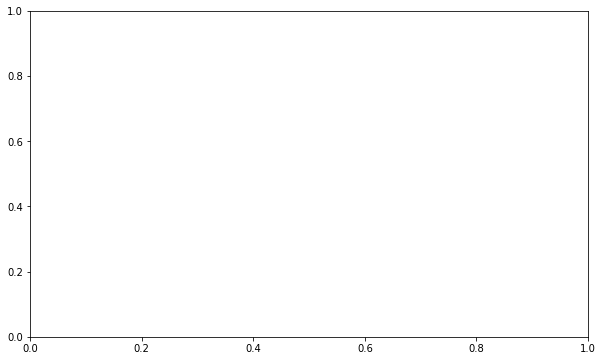

In [11]:
# Plot the signal and background LLHs
fig, ax = plt.subplots(figsize=(10,6))
bins = np.linspace(0, 500, 50)

ax.hist(background_fits['ts'],
        bins = bins,
        weights = np.ones(background_fits.shape[0])/len(background_fits),
        histtype = 'step',
        color = 'k',
        linewidth = 3,
        alpha=0.5,
        label = r'N = 0')

ax.hist(signal_16_fits['ts'],
        bins = bins,
        weights = np.ones(signal_16_fits.shape[0])/len(signal_16_fits),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $10^{-16}$')

ax.hist(signal_15_fits['ts'],
        bins = bins,
        weights = np.ones(signal_15_fits.shape[0])/len(signal_15_fits),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $10^{-15}$')

ax.hist(signal_14_fits['ts'],
        bins = bins,
        weights = np.ones(signal_14_fits.shape[0])/len(signal_14_fits),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $10^{-14}$')

ax.legend(loc='upper right', fontsize=16,)

ax.grid(alpha=0.25)
ax.set_yscale('log')
ax.set_xlabel("TS", fontsize=16)
ax.set_ylabel("Fraction of Trials", fontsize=16)
ax.tick_params(which='both', labelsize=16)

In [ ]:
# Try it again, but using a gaussian signal this time.
# WARNING: The gaussian time profile is kind of hacked
# together and may not give the most reliable results.
# Use with caution!
thousand_seconds = (1000.0)/(24*3600.)
llh_object.background_time_profile = uniform_profile.UniformProfile(56044.0912963, 56044.0912963+thousand_seconds)
llh_object.signal_time_profile = gauss_profile.GaussProfile(56044.0912963 + thousand_seconds/2, thousand_seconds/10)

background_fits = llh_object.produce_n_trials(1000, test_ns = 0.1)
signal_16_fits = llh_object.produce_n_trials(1000, N=1e-16, test_ns = 0.1)
signal_15_fits = llh_object.produce_n_trials(1000, N=1e-15, test_ns = 0.1)
signal_14_fits = llh_object.produce_n_trials(1000, N=1e-14, test_ns = 0.1)

NameError: name 'background_fits' is not defined

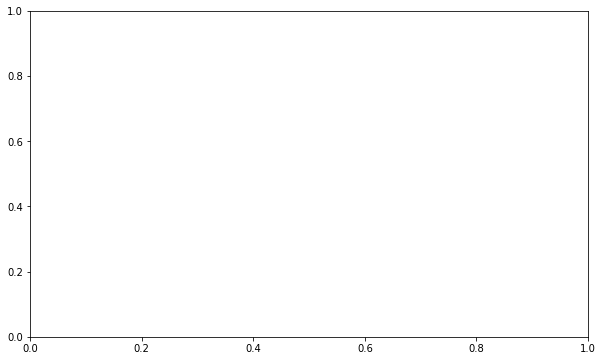

In [12]:
# Plot the signal and background LLHs
fig, ax = plt.subplots(figsize=(10,6))
bins = np.linspace(0, 500, 50)

ax.hist(background_fits['ts'],
        bins = bins,
        weights = np.ones(background_fits.shape[0])/len(background_fits),
        histtype = 'step',
        color = 'k',
        linewidth = 3,
        alpha=0.5,
        label = r'N = 0')

ax.hist(signal_16_fits['ts'],
        bins = bins,
        weights = np.ones(signal_16_fits.shape[0])/len(signal_16_fits),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $10^{-16}$')

ax.hist(signal_15_fits['ts'],
        bins = bins,
        weights = np.ones(signal_15_fits.shape[0])/len(signal_15_fits),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $10^{-15}$')

ax.hist(signal_14_fits['ts'],
        bins = bins,
        weights = np.ones(signal_14_fits.shape[0])/len(signal_14_fits),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $10^{-14}$')

ax.legend(loc='upper right', fontsize=16,)

ax.grid(alpha=0.25)
ax.set_yscale('log')
ax.set_xlabel("TS", fontsize=16)
ax.set_ylabel("Fraction of Trials", fontsize=16)
ax.tick_params(which='both', labelsize=16)

In [13]:
thousand_seconds = (50000.0)/(24*3600.)
# means  = [56044.0912963 + thousand_seconds/5,56044.0912963 + thousand_seconds/3,
#           56044.0912963 + thousand_seconds/4,56044.0912963 + thousand_seconds/5,
#           56044.0912963 + 3*thousand_seconds/4]
# sigmas = [thousand_seconds/10,thousand_seconds/11,
#           thousand_seconds/8,thousand_seconds/5,
#           thousand_seconds/20]
llh_object.background_time_profile = uniform_profile.UniformProfile(56044.0912963, 56044.0912963+thousand_seconds)
# llh_object.signal_time_profile = n_gauss_profile(means, sigmas)
llh_object.signal_time_profile = gauss_profile.GaussProfile(56044.0912963 + thousand_seconds/2, thousand_seconds/10)

trial = llh_object.produce_trial(N = 1e-14)

ERROR: No runs found in GRL for calculation of background rates!


RuntimeError: 

ValueError: `bins` must be positive, when an integer

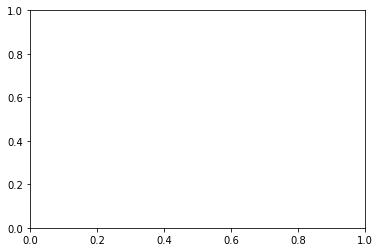

In [14]:
counts, bins, _ = plt.hist(trial['time'], bins = len(trial)//5)

In [18]:
from sklearn.cluster import DBSCAN

In [19]:
X = trial['time'].reshape(-1, 1)
db = DBSCAN(eps=.01, min_samples=2).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

In [20]:
labels = db.labels_
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

NameError: name 'db' is not defined

In [21]:
for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    
    plt.hist(xy, bins = bins)

NameError: name 'unique_labels' is not defined